In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import glob
from matplotlib import pyplot as plt
# import fastwer
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

2022-11-09 01:18:50.625570: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
Img = np.load('../input/npyword/Img.npy')
Padded_txt = np.load('../input/npyword/Padded_txt.npy')
Input_length = np.load('../input/npyword/Input_length.npy')
Label_length = np.load('../input/npyword/Label_length.npy')
Labels = np.load('../input/npyword/Labels.npy')
max_label_len = np.load('../input/npyword/max_label_len.npy')

In [ ]:
train_img, valid_img,train_padded_txt, \
valid_padded_txt, train_input_length,\
valid_input_length, train_label_length, \
valid_label_length,train_Labels,\
valid_Labels = train_test_split(Img, Padded_txt, Input_length, 
												  Label_length, 
												  Labels,
												  test_size = 0.15, random_state = 0)

In [ ]:
def sque(x):
    return K.squeeze(x, axis = 1)

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def convolutional_block(layer_in, filters, kernel_size, pool_size, strides, block):
    """
    Implementation of the convolutional block 
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- integer, defining the number of filters in the CONV layer
    kernel_size
    pool_size
    block -- string/character, used to name the layers, depending on their position in the network
    stride -- Integer, specifying the stride to be used
    
    Returns:
    layer_out -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    L2 = 1.0e-6
    # defining name basis
    conv_name_base = 'Convolution' + str(block) 
    bn_name_base = 'Batch' + str(block) 
    pool_name_base = 'Pool' + str(block) 

    X = Conv2D(filters = filters, kernel_size = kernel_size, activation = 'relu', padding = 'same', 
    		   name = conv_name_base, kernel_regularizer = regularizers.l2(L2))(layer_in) 
    X = BatchNormalization(name = bn_name_base)(X)
    X = Dropout(0.2)(X)
    layer_out = MaxPool2D(pool_size = pool_size, strides = strides, name = pool_name_base)(X)

    return layer_out

In [ ]:
threshold = [32, 128]
char_list = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789\
			 ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặ\
			 ẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ "
inputs = Input(shape=(threshold[0], threshold[1],1))

x = convolutional_block(layer_in=inputs, filters=64, kernel_size=(3,3), 
						pool_size=(2,2), strides=2, block=1)

x = convolutional_block(layer_in=x, filters=128, kernel_size=(3,3), 
						pool_size=(2,2), strides=2, block=2)

x = convolutional_block(layer_in=x, filters=256, kernel_size=(3,3), 
						pool_size=(2,2), strides=2, block=3)
 
x = convolutional_block(layer_in=x, filters=256, kernel_size=(3,3), 
						pool_size=(2,1), strides = 1, block=4)

x = convolutional_block(layer_in=x, filters=512, kernel_size=(3,3), 
						pool_size=(2,1), strides=1, block=5)

x = convolutional_block(layer_in=x, filters=512, kernel_size=(3,3), 
						pool_size=(2,1), strides=1, block=6)
 
squeezed = sque(x)
 
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25),
                        name = 'LSTM_1')(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25),
                        name='LSTM_2')(blstm_1)
 
outputs = Dense(len(char_list)+1, activation='softmax', name='fully_connected')(blstm_2)

act_model = Model(inputs, outputs)
act_model.summary()

2022-11-09 01:19:19.879019: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-09 01:19:19.884258: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-09 01:19:19.947766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 01:19:19.948500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-11-09 01:19:19.948562: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-11-09 01:19:19.973869: I tensorflow/stream_executor/platform/def

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
Convolution1 (Conv2D)        (None, 32, 128, 64)       640       
_________________________________________________________________
Batch1 (BatchNormalization)  (None, 32, 128, 64)       256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 128, 64)       0         
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 64, 64)        0         
_________________________________________________________________
Convolution2 (Conv2D)        (None, 16, 64, 128)       73856     
_________________________________________________________________
Batch2 (BatchNormalization)  (None, 16, 64, 128)       512   

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

In [ ]:
loss_out = Lambda(ctc_lambda_func, 
                  output_shape=(1,), 
                  name='ctc')([outputs, labels, input_length, label_length])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model = Model(inputs=[inputs, labels, input_length, label_length], 
			  outputs=loss_out)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, 
			  optimizer=optimizer)

In [ ]:
batch_size = 64
epochs = 50
filepath = "best_model.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', 
							 verbose=1, save_best_only=True, 
							 mode='auto')
#------------------------------------------------
history = model.fit(x=[train_img, train_padded_txt, 
			train_input_length, train_label_length], 
		  y=np.zeros(len(train_img)), 
		  batch_size=batch_size, 
		  epochs = epochs,
          callbacks = checkpoint,
		  validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], 
		  					 [np.zeros(len(valid_img))]))

2022-11-09 01:19:25.310527: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1542291456 exceeds 10% of free system memory.
2022-11-09 01:19:26.786080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-09 01:19:26.798577: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/50


2022-11-09 01:19:32.585756: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-11-09 01:19:33.366069: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-11-09 01:19:33.402339: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1471/1471 [==============================] - ETA: 0s - loss: 16.2483

2022-11-09 01:21:03.646984: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 272171008 exceeds 10% of free system memory.


1471/1471 [==============================] - 108s 65ms/step - loss: 16.2449 - val_loss: 7.1933

Epoch 00001: val_loss improved from inf to 7.19333, saving model to best_model.h5
Epoch 2/50
1471/1471 [==============================] - 92s 62ms/step - loss: 5.7436 - val_loss: 4.4004

Epoch 00002: val_loss improved from 7.19333 to 4.40036, saving model to best_model.h5
Epoch 3/50
1471/1471 [==============================] - 92s 62ms/step - loss: 3.5890 - val_loss: 2.8397

Epoch 00003: val_loss improved from 4.40036 to 2.83972, saving model to best_model.h5
Epoch 4/50
1471/1471 [==============================] - 92s 62ms/step - loss: 2.5404 - val_loss: 2.1399

Epoch 00004: val_loss improved from 2.83972 to 2.13986, saving model to best_model.h5
Epoch 5/50
1471/1471 [==============================] - 91s 62ms/step - loss: 1.9693 - val_loss: 1.6302

Epoch 00005: val_loss improved from 2.13986 to 1.63016, saving model to best_model.h5
Epoch 6/50
1471/1471 [==============================] - 90

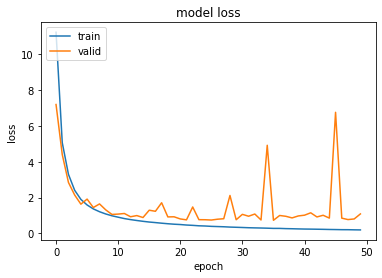

In [ ]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
act_model.save('./model_v4.h5')

In [ ]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):

    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
  
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
 
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

In [ ]:
y_true = valid_Labels
correct_char = 0
total_char = 0
correct = 0
total = 0
test_wer, test_cer = [], []
for index in range(len(valid_img)):
    prediction = model.predict(valid_img[index][None, :, :, :])
    out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                                greedy=True)[0][0])
    predicted_str = ''
    for x in (out):
        for p in x:  
            if int(p) != -1:
                predicted_str += char_list[int(p)]
    print(predicted_str)
    if predicted_str == y_true[index]:
        correct += 1
        correct_char += len(y_true[index])
    total += 1
    total_char += len(y_true[index])
    test_wer.append(wer(y_true[index], predicted_str))
    test_cer.append(cer(y_true[index], predicted_str))

avg_cer = sum(test_cer)/len(test_cer)
avg_wer = sum(test_wer)/len(test_wer)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 196ms/step
phồn
1/1 [==============================] - 0s 25ms/step
chay
1/1 [==============================] - 0s 20ms/step
cũng
1/1 [==============================] - 0s 24ms/step
họ
1/1 [==============================] - 0s 27ms/step
nhựa
1/1 [==============================] - 0s 25ms/step
chi
1/1 [==============================] - 0s 26ms/step
dì
1/1 [==============================] - 0s 25ms/step
cảm
1/1 [==============================] - 0s 24ms/step
rình
1/1 [==============================] - 0s 23ms/step
kiếm
1/1 [==============================] - 0s 171ms/step
một
1/1 [==============================] - 0s 22ms/step
cá
1/1 [==============================] - 0s 23ms/step
tạt
1/1 [==============================] - 0s 24ms/step
được
1/1 [==============================] - 0s 25ms/step
cậu
1/1 [==============================] - 0s 25ms/step
bán
1/1 [==============================] - 0s 29ms/

In [ ]:
print('Average CER: %.2f%%' % (avg_cer*100))
print('Average WER: %.2f%%' % (avg_wer*100))
print('Character Accuracy: %.2f%%' % (correct_char/total_char*100))
print('Word Accuracy: %.2f%%' % (correct/total*100))

Average CER: 6.95%
Average WER: 16.96%
Character Accuracy: 82.72%
Word Accuracy: 83.04%
